# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [2]:
from google.colab import drive
import os
import cv2
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

ATnT = "/content/drive/MyDrive/ATnT"

Mounted at /content/drive


In [3]:
trainAmt = 0.9
allFaces = []
labels = []

for i in range(1, 41):
    for j in range(1, 11):
        imgPath = os.path.join("/content/drive/MyDrive/ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)):]
testLabels = labels[int(trainAmt*len(allFaces)):]

print(trainFaces.shape, trainLabels.shape)
print(trainFaces)

(360, 112, 92) (360,)
[[[ 49  50  48 ...  44  47  43]
  [ 50  50  55 ...  48  45  44]
  [ 52  62  56 ...  47  47  48]
  ...
  [115 115 108 ...  58  70  68]
  [117 121 120 ...  66  70  73]
  [125 119 122 ...  73  77  71]]

 [[116 116 117 ... 114 117 114]
  [115 118 117 ... 113 120 115]
  [111 121 111 ... 113 116 116]
  ...
  [101  96 101 ...  21  25  24]
  [103  93 100 ...  17  27  19]
  [ 98  96  98 ...  19  24  16]]

 [[115 108 109 ... 106 108 109]
  [108 107 111 ... 107 107 107]
  [106 109 106 ... 110 107 108]
  ...
  [ 96  84  73 ...  48  40  47]
  [ 91  87  75 ...  49  50  51]
  [100  80  84 ...  48  47  48]]

 ...

 [[117 115 115 ... 111 112 109]
  [114 115 114 ... 111 110 110]
  [117 111 115 ... 111 112 110]
  ...
  [ 63  65  65 ...  81  41  39]
  [ 66  64  67 ...  78  44  47]
  [ 72  66  70 ...  53  46  68]]

 [[122 119 123 ... 114 112 113]
  [122 118 119 ... 115 113 113]
  [121 120 120 ... 113 111 114]
  ...
  [ 96  93  95 ...  81  84  82]
  [ 94  94  93 ...  82  85  80]
  [ 96

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [4]:
import numpy as np

def pca(X, num_components=0):
    mean_face = np.mean(X, axis=0)
    X_normalized = X - mean_face

    C = np.dot(X_normalized.T, X_normalized) / (X_normalized.shape[0]-1)

    eigenvalues, eigenvectors = np.linalg.eigh(C)

    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]

    if num_components < eigenvectors.shape[1] and num_components > 0:
        eigenvectors = eigenvectors[:, :num_components]

    return eigenvectors, eigenvalues, mean_face

num_components = 100
eigenvectors, eigenvalues, mean_face = pca(trainFaces.reshape(trainFaces.shape[0], -1), num_components)

print("Eigenvectors shape:", eigenvectors.shape)
print("Eigenvalues:", eigenvalues[:10])


Eigenvectors shape: (10304, 100)
Eigenvalues: [2833526.55048752 2104981.00464115 1126657.02770855  901251.67617368
  799116.84521018  526658.94780705  391396.30126608  382150.40166345
  324579.61083145  299807.27056377]


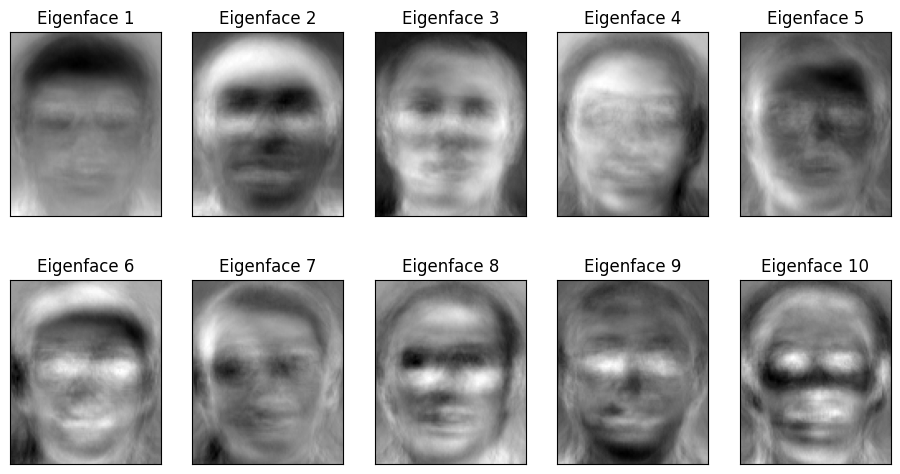

In [5]:
# plot the eigen faces
# %matplotlib inline

eigen_faces = eigenvectors

def plot_eigenfaces(eigenvectors, h=112, w=92, n_row=2, n_col=5):
    """Plot the first few eigenfaces."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(eigenvectors[:, i].reshape(h, w), cmap='gray')
        plt.title('Eigenface %d' % (i + 1))
        plt.xticks(())
        plt.yticks(())
    plt.show()

plot_eigenfaces(eigenvectors, 112, 92, 2, 5)


#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [6]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Reconstruct the testFace using the eigenFaces and meanFace.

    Parameters:
    - testFace: The test face to be reconstructed, should be flattened into a vector.
    - eigenFaces: The Eigen faces (principal components), each column is an eigenface.
    - meanFace: The mean face of the training data, flattened into a vector.

    Returns:
    - reconstructedFace: The reconstructed face.
    """
    centeredFace = testFace - meanFace

    coefficients = np.dot(eigenFaces.T, centeredFace)

    reconstruction = np.dot(eigenFaces, coefficients)

    reconstructedFace = reconstruction + meanFace

    return reconstructedFace


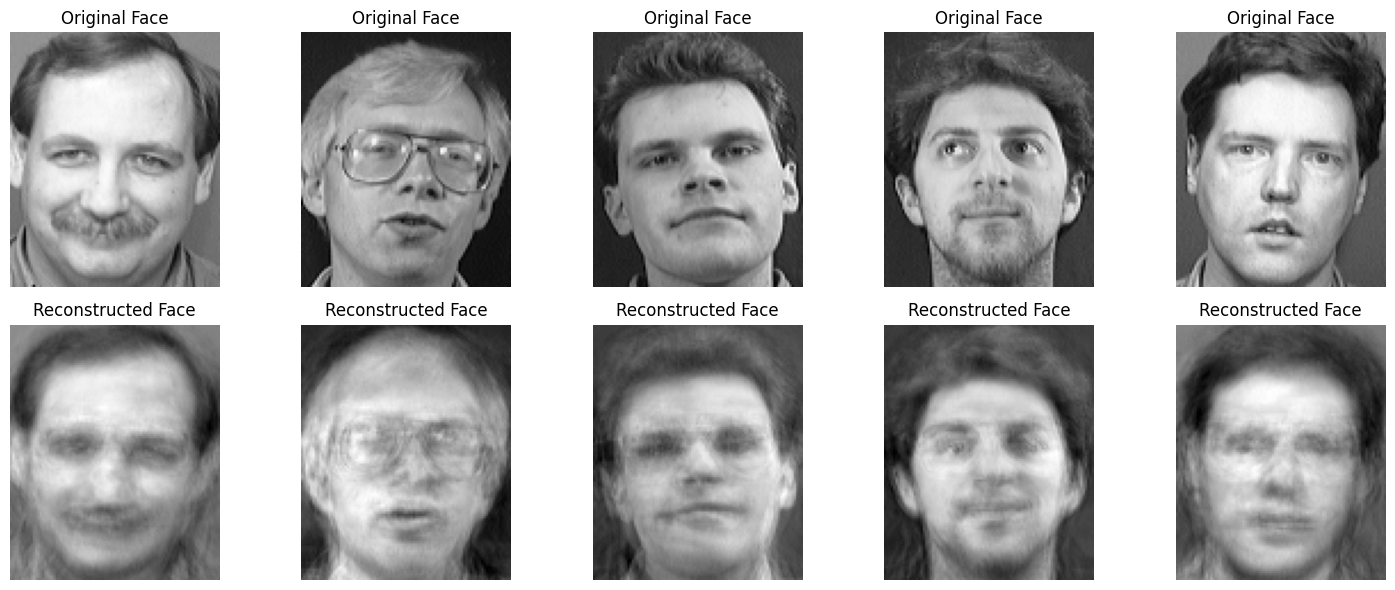

In [7]:
import numpy as np
import matplotlib.pyplot as plt

num_faces = 5

plt.figure(figsize=(15, 6))
for i in range(num_faces):
    original_face = testFaces[i]
    flattened_test_face = original_face.flatten()

    reconstructed_face = imageReconstruction(flattened_test_face, eigen_faces, mean_face)

    plt.subplot(2, num_faces, i + 1)
    plt.imshow(original_face, cmap='gray')
    plt.title('Original Face')
    plt.axis('off')

    plt.subplot(2, num_faces, num_faces + i + 1)
    plt.imshow(reconstructed_face.reshape(112, 92), cmap='gray')  # Reshape reconstructed_face back to 112x92 for display
    plt.title('Reconstructed Face')
    plt.axis('off')

plt.tight_layout()
plt.show()


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

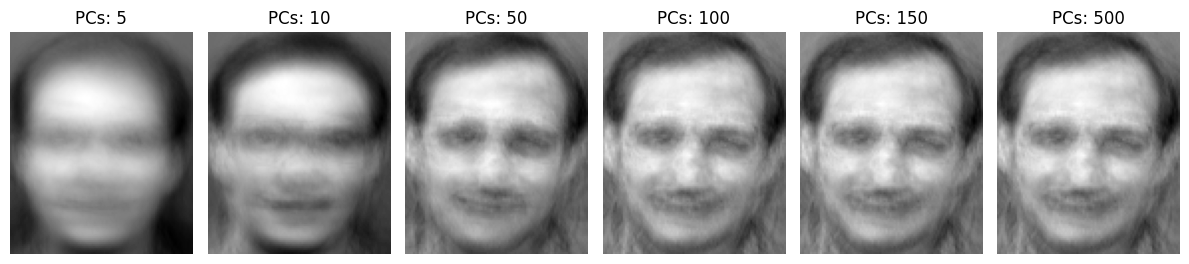

In [8]:
import matplotlib.pyplot as plt

def displayNfactors(testFace, eigenFaces, meanFace, num_factors_list):
    """
    Visualize the reconstruction results for different numbers of factors (PCs).

    Parameters:
    - testFace: Single test face to be reconstructed, flattened into a vector.
    - eigenFaces: Array of Eigenfaces (principal components), each column is an eigenface.
    - meanFace: Mean face of the training data, flattened into a vector.
    - num_factors_list: List of numbers of factors (PCs) to use for reconstruction.

    Returns:
    - None, displays a plot.
    """
    plt.figure(figsize=(2 * len(num_factors_list), 4))
    testFace = testFace.flatten()

    for i, num_factors in enumerate(num_factors_list):
        selected_eigenFaces = eigenFaces[:, :num_factors]

        reconstructedFace = imageReconstruction(testFace, selected_eigenFaces, meanFace)

        plt.subplot(1, len(num_factors_list), i + 1)
        plt.imshow(reconstructedFace.reshape(112, 92), cmap='gray')
        plt.title(f'PCs: {num_factors}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

testFace = testFaces[0]

num_factors_list = [5, 10, 50, 100, 150, 500]

displayNfactors(testFace, eigen_faces, mean_face, num_factors_list)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [9]:
import numpy as np

def getClass(test_image, eigen_vectors, mean_face, X_train, y_train):
    centered_test_image = test_image.flatten() - mean_face

    test_image_projection = np.dot(eigen_vectors.T, centered_test_image)

    min_error = np.inf
    prediction_class = -1
    best_match_image = None

    for i, train_image in enumerate(X_train):

        centered_train_image = train_image.flatten() - mean_face

        train_image_projection = np.dot(eigen_vectors.T, centered_train_image)

        error = np.linalg.norm(test_image_projection - train_image_projection)

        if error < min_error:
            min_error = error
            best_match_image = train_image
            prediction_class = y_train[i]

    return best_match_image, min_error, prediction_class


Iterate through all the images in the test data and test the accuracy by taking different number of components

Accuracy with 3 components: 65.00%
Mean Squared Error with 3 components: 84.32
Accuracy with 5 components: 82.50%
Mean Squared Error with 5 components: 76.69
Accuracy with 10 components: 97.50%
Mean Squared Error with 10 components: 73.37
Accuracy with 15 components: 97.50%
Mean Squared Error with 15 components: 73.16
Accuracy with 20 components: 97.50%
Mean Squared Error with 20 components: 73.11
Accuracy with 25 components: 97.50%
Mean Squared Error with 25 components: 72.96
Accuracy with 50 components: 97.50%
Mean Squared Error with 50 components: 72.98
Accuracy with 100 components: 97.50%
Mean Squared Error with 100 components: 72.71
Accuracy with 200 components: 97.50%
Mean Squared Error with 200 components: 72.71
Accuracy with 300 components: 97.50%
Mean Squared Error with 300 components: 72.71


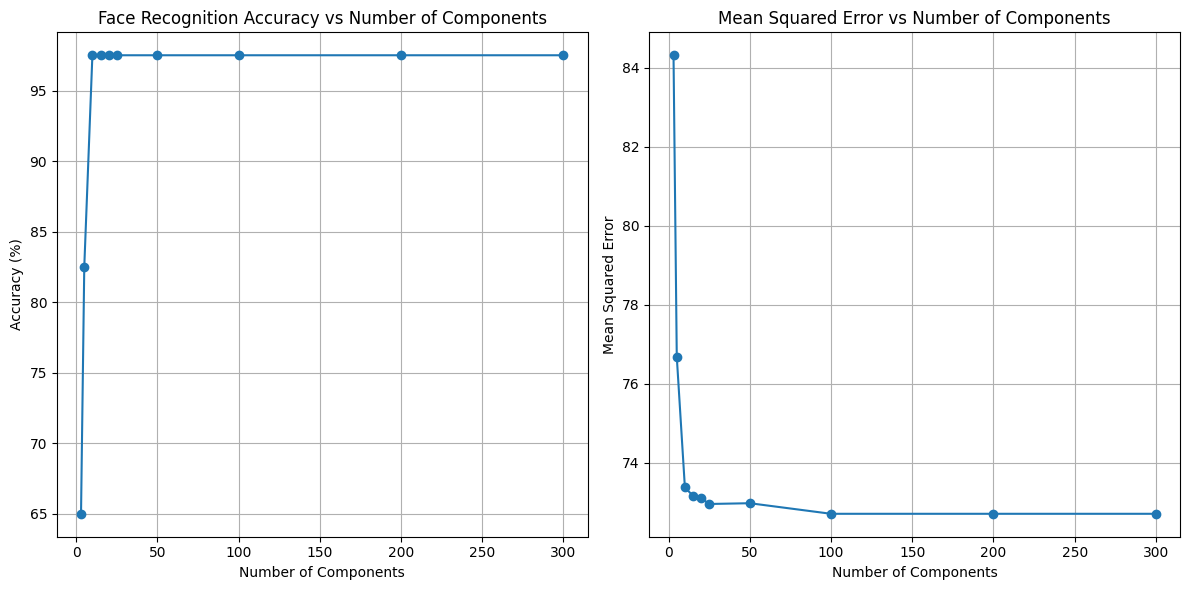

In [14]:
def face_recognition_accuracy(X_train, y_train, X_test, y_test, eigen_vectors, mean_face, num_components_list):
    accuracies = []
    mean_squared_errors = []
    for num_components in num_components_list:
        correct_predictions = 0
        total_squared_error = 0
        for i, test_image in enumerate(X_test):
            best_match_image, _, predicted_class = getClass(test_image, eigen_vectors[:, :num_components], mean_face, X_train, y_train)
            squared_error = np.mean((best_match_image.flatten() - test_image.flatten()) ** 2)
            total_squared_error += squared_error
            if predicted_class == y_test[i]:
                correct_predictions += 1
        accuracy = correct_predictions / len(y_test) * 100
        mse = total_squared_error / len(y_test)
        accuracies.append(accuracy)
        mean_squared_errors.append(mse)
        print(f"Accuracy with {num_components} components: {accuracy:.2f}%")
        print(f"Mean Squared Error with {num_components} components: {mse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(num_components_list, accuracies, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (%)')
    plt.title('Face Recognition Accuracy vs Number of Components')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_components_list, mean_squared_errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs Number of Components')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

num_components_list = [3, 5, 10, 15, 20, 25, 50, 100, 200, 300]

face_recognition_accuracy(trainFaces, trainLabels, testFaces, testLabels, eigenvectors, mean_face, num_components_list)
